# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 : 

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [67]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2023-01-16 18:15:26--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2023-01-16 18:15:26--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.001s  

2023-01-16 18:15:26 (27.0 MB/s) - ‘imagenet_classes.pkl’ saved [35454

188
Predicted Class :  wire-haired fox terrier


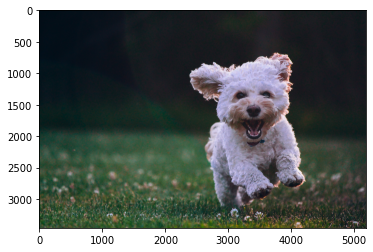

In [19]:
# cat = Image.open('cat.jpg')
dog = Image.open('dog.jpg')
# plt.imshow(cat)
plt.imshow(dog)
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True).eval()

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
# img = Image.open("cat.jpg")
img = Image.open("dog.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img = (img - mean.reshape(3, 1, 1)) / std.reshape(3, 1, 1)

img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x) # TODO calcul forward
y = y.detach().numpy() # transformation en array numpy

class_idx = y.argmax()
print(class_idx)
print('Predicted Class : ', imagenet_classes[class_idx])


## Visualize activation maps

In [4]:
from keras.applications.vgg16 import VGG16
from keras import Model

In [5]:
model = VGG16()

553467096/553467096 [==============================] - 14s 0us/step


In [6]:
first_conv_layer = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [7]:
keras_img = img.reshape((img.shape[0], img.shape[2], img.shape[3], img.shape[1]))

In [8]:
feature_map = first_conv_layer.predict(keras_img)

1/1 [==============================] - 6s 6s/step


In [9]:
feature_map.shape

(1, 224, 224, 64)

In [10]:
activation_map = feature_map.sum(axis=-1, keepdims=True)
# activation_map = feature_map[0, :, :, 1]
activation_map = activation_map.reshape(224, 224)

In [11]:
activation_map /= activation_map.max()

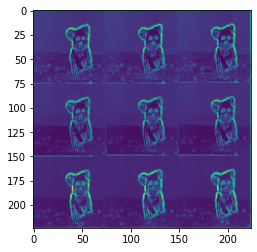

In [12]:
plt.imshow(activation_map)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

In [ ]:
ls 15SceneData/test/bedroom/

In [21]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # self.avgpooling = vgg16.avgpool
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-5])
  def forward(self, x):
    x = self.features(x)
    # x = self.avgpooling(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [7]:
class TroncatedVGG19(nn.Module):
  def __init__(self):
    super(TroncatedVGG19, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg19.features.children()))
    self.avgpooling = nn.Sequential(*list(vgg19.avgpool.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg19.classifier.children())[:-5])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


In [10]:
class TroncatedResNet50(nn.Module):
  def __init__(self):
    super(TroncatedResNet50, self).__init__()
    
    self.conv1 = resnet50.conv1
    self.bn1 = resnet50.bn1
    self.relu = resnet50.relu
    self.maxpool = resnet50.maxpool
    self.layer1 = nn.Sequential(*list(resnet50.layer1.children()))
    self.layer2 = nn.Sequential(*list(resnet50.layer2.children()))
    self.layer3 = nn.Sequential(*list(resnet50.layer3.children()))
    self.layer4 = nn.Sequential(*list(resnet50.layer4.children()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = x.view(x.size(0), -1)

    return x

In [ ]:
vgg16

In [44]:
class VGG16NewClassif(nn.Module):
  def __init__(self):
    super(VGG16NewClassif, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))
    self.avgpooling = vgg16.avgpool
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
    self.final = nn.Linear(in_features=4096, out_features=15, bias=True)

  def forward(self, x):
    x = self.features(x)
    # x = self.avgpooling(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    x = self.final(x)
    return x

In [11]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [74]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    X = []
    y = []
    ####################
    ##      FIN        #
    ####################
    
    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        X.append(model(input).detach().cpu())
        y.append(target)
        ####################
        ##      FIN        #
        ####################  
      
    return torch.cat(X), torch.hstack(y)


def main(path="15SceneData", batch_size=8):
    # print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)
    # vgg19 = models.vgg19(pretrained=True) 
    # resnet50 = models.resnet50(pretrained=True)

    # print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7()
    # model = TroncatedResNet50() 
    # model = VGG16NewClassif()
    ####################
    ##      FIN        #
    ####################      
    
    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # # Extraction des features
    # print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    # print('Apprentissage des SVM')
    
    svm = LinearSVC(C=1.0)
    pca = PCA(n_components=1024)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.fit_transform(X_test)
    svm.fit(X_train_reduced, y_train)
    accuracy = svm.score(X_test_reduced, y_test)
    ####################
    ##      FIN        #
    ####################    

    # optimizer = torch.optim.Adam(model.final.parameters())
    # # Training VGG16
    # accuracy = 0
    # for epoch in range(20):
    #     print('Epoch', epoch)
    #     model.train()
    #     for i, (input, target) in enumerate(train):
    #         optimizer.zero_grad()
    #         yhat = model(input.cuda())
    #         loss = F.cross_entropy(yhat, target.cuda())
    #         loss.backward()
    #         optimizer.step()
    #     if epoch % 2 == 0:
    #         model.eval()
    #         newaccuracy = 0
    #         for i, (input, target) in enumerate(test):
    #             yhat = model(input.cuda()) 
    #             yhat = yhat.argmax(dim=1)
    #             newaccuracy += (yhat==target.cuda()).sum()
                
    #         newaccuracy = float(newaccuracy)
    #         newaccuracy /= len(test)
    #     if newaccuracy < accuracy:
    #         break
    #     accuracy = newaccuracy
    
    print('Accuracy = %f' % accuracy)


In [75]:
main("15SceneData", 8)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Récupération des données
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Accuracy = 0.157119


In [ ]:
512 0.157
128 0.157